# CS 4501: Computer Vision -- Detecting Human Emotions through Videos
### Akira Durham (zup9su) and Sebastian Borromeo (uwg3xs)

In [44]:
# imports
# !pip install --upgrade numpy==1.26.4
# !pip install torchcam
# !pip install --upgrade --force-reinstall torchvision
import csv
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchcam.methods import GradCAM
import matplotlib.pyplot as plt
import time
import torchvision.models as models
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix


from google.colab.patches import cv2_imshow
from IPython.display import display, clear_output

### Methods

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [2]:
class ProcessData(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = Image.fromarray(self.data[idx])
        label = self.labels[idx]
        data = self.transform(data)

        return data, label

In [3]:
# https://pytorch.org/vision/main/transforms.html
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.35),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.35),
    transforms.RandomApply([transforms.RandomResizedCrop(size=48, scale=(0.8, 1.2))], p=0.35),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.35),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
transform_train_vgg = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.35),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.35),
    transforms.RandomApply([transforms.RandomResizedCrop(size=224, scale=(0.8, 1.2))], p=0.35),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.35),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
transform_test_vgg = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [ ]:
transform_train_res = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.35),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.35),
    transforms.RandomApply([transforms.RandomResizedCrop(size=224, scale=(0.8, 1.2))], p=0.35),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.35),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test_res = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
def get_accuracy(logit, target, batch_size):
    """Obtain accuracy for training round"""
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    ret_acc = 100.0 * corrects / batch_size
    return ret_acc.item()

# Data Processing

Data was pulled from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data, which is FER2013's Kaggle competition, providing separated training and test datasets already.

In [5]:
# load in .csv
with open('fer2013.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    for i, row in enumerate(reader):
        if len(row) != 3:
            print(f"Row {i} has {len(row)} columns: {row}")

input_data = np.loadtxt('fer2013.csv', delimiter=',', skiprows=1, dtype=str)
# input_data = input_data[input_data[:, 0] != '1']

In [6]:
# extract emotion labels
all_labels = input_data[:, 0].astype(int)

In [7]:
# create np array from stacked pixel vals + ensure sizing
pixel_data = np.array([np.fromstring(row, dtype=np.uint8, sep=' ') for row in input_data[:, 1]])
pixel_data = pixel_data.reshape(-1, 48, 48)

In [8]:
# get indices from input_data
train_indices = np.where(input_data[:, 2] == 'Training')[0]
test_indices = np.where(input_data[:, 2] == 'PublicTest')[0]
split_t = int(0.8 * len(train_indices))

In [9]:
# create datasets using custom class
train_set = ProcessData(pixel_data[train_indices[split_t:]], all_labels[train_indices[split_t:]], transform=transform_train)
validate_set = ProcessData(pixel_data[train_indices[:split_t]], all_labels[train_indices[:split_t]], transform=transform_test)
test_set = ProcessData(pixel_data[test_indices], all_labels[test_indices], transform=transform_test)

In [10]:
batch_size = 64
train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
vald = DataLoader(validate_set, batch_size=batch_size, shuffle=False)
test = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# CNN Model Building

https://github.com/gitshanks/fer2013/blob/master/fertrain.py
https://www.kaggle.com/code/mohamedchahed/human-emotion-detection/notebook#Modeling
https://github.com/sdhayalk/Facial_Emotion_Recognition/blob/master/Fer_CNN_FloydHub_Keras.py

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )

        self.fc = nn.Sequential(
            nn.Linear(512 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [14]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),

            nn.Linear(256, 7)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.fc_block(x)
        return x

In [15]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64),
            nn.Dropout(0.2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(128),
            nn.Dropout(0.2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(256),
            nn.Dropout(0.2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(512),
            nn.Dropout(0.2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 3 * 3, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 7)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.fc(x)
        return x

# Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN3().to(device)
fine_tune = False

# Hyperparameters
num_epochs = 150
batch_size = 64
momentum = 0.9
learning_rate = 0.01

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-6)

train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
vald = DataLoader(validate_set, batch_size=batch_size, shuffle=False)
test = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
model = models.vgg16(weights='DEFAULT')
model.classifier[6] = nn.Linear(4096, 7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
fine_tune = True
for param in model.features.parameters():
    param.requires_grad = False
for param in model.classifier[6].parameters():
    param.requires_grad = True

# Hyperparameters FOR PRETRAINED TRANSFER MODELS VGG ONLY
num_epochs = 30
batch_size = 64
learning_rate = 0.0001
freeze_epochs = 8

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

train_set = ProcessData(pixel_data[train_indices[split_t:]], all_labels[train_indices[split_t:]], transform=transform_train_vgg)
validate_set = ProcessData(pixel_data[train_indices[:split_t]], all_labels[train_indices[:split_t]], transform=transform_test_vgg)
test_set = ProcessData(pixel_data[test_indices], all_labels[test_indices], transform=transform_test_vgg)

train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
vald = DataLoader(validate_set, batch_size=batch_size, shuffle=False)
test = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.0MB/s]


In [ ]:
model = models.resnet18(weights='DEFAULT')
model.fc = nn.Linear(model.fc.in_features, 7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
fine_tune = True
for name, param in model.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False

# Hyperparameters FOR PRETRAINED TRANSFER MODELS VGG ONLY
num_epochs = 30
batch_size = 64
learning_rate = 0.0001

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

train_set = ProcessData(pixel_data[train_indices[split_t:]], all_labels[train_indices[split_t:]], transform=transform_train_res)
validate_set = ProcessData(pixel_data[train_indices[:split_t]], all_labels[train_indices[:split_t]], transform=transform_test_res)
test_set = ProcessData(pixel_data[test_indices], all_labels[test_indices], transform=transform_test_res)

train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
vald = DataLoader(validate_set, batch_size=batch_size, shuffle=False)
test = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 22.5MB/s]


In [ ]:
training_stat = []
best_val_acc = 0
early_stopping_patience = 10
cur_patience = 0
temp_lr = learning_rate

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    train_running_loss = 0.0
    train_acc = 0.0

    if fine_tune and epoch % 8 == 0 and epoch < 30:
        # VGG
        # if epoch == 8:
        #     for param in model.features[15:].parameters():
        #         param.requires_grad = True
        # elif epoch == 16:
        #     for param in model.features[10:].parameters():
        #         param.requires_grad = True
        #     for param in model.classifier[3:].parameters():
        #         param.requires_grad = True
        # elif epoch == 24:
        #     for param in model.features[5:].parameters():
        #         param.requires_grad = True
        #     for param in model.classifier.parameters():
        #         param.requires_grad = True

        # RESNET
        if epoch == 8:
            for param in model.layer4.parameters():
                param.requires_grad = True
        elif epoch == 16:
            for param in model.layer3.parameters():
                param.requires_grad = True
        elif epoch == 24:
            for param in model.layer2.parameters():
                param.requires_grad = True

        temp_lr *= 0.1
        for rate in optimizer.param_groups:
            rate['lr'] = temp_lr * 0.1


    for images, labels in train:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, batch_size)

    model.eval()
    val_acc = 0.0
    val_running_loss = 0.0

    with torch.no_grad():
        for images, labels in vald:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)

            val_running_loss += loss.detach().item()
            val_acc += get_accuracy(logits, labels, batch_size)

    if fine_tune:
        scheduler.step()
    else:
        scheduler.step(val_acc / len(vald.dataset))

    end_time = time.time()
    epoch_time = end_time - start_time

    training_stat.append([epoch, epoch_time, train_running_loss / len(train), train_acc / len(train), val_running_loss / len(vald), val_acc / len(vald)])
    print('Epoch: %d | Time: %.2fs | Train Loss: %.2f | Train Accuracy: %.2f | Validation Loss: %.2f | Validation Accuracy: %.2f'
          % (epoch, epoch_time, train_running_loss / len(train), train_acc / len(train), val_running_loss / len(vald), val_acc / len(vald)))

    if val_acc / len(vald) > best_val_acc:
        cur_patience = 0
        best_val_acc = val_acc / len(vald)
        torch.save(model.state_dict(), 'model_res.pth')
        np.savetxt("final_training_log_model_res.csv", np.array(training_stat), delimiter=",",
          header="Epoch,Time,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy",
          comments='', fmt='%.2f')
    else:
        cur_patience += 1
        if cur_patience >= early_stopping_patience:
            np.savetxt("final_training_log_model_res.csv", np.array(training_stat), delimiter=",",
            header="Epoch,Time,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy",
            comments='', fmt='%.2f')
            print(f"Early stopping triggered.\n Best Accuracy: {best_val_acc:.4f}")
            break

Epoch: 0 | Time: 85.70s | Train Loss: 1.77 | Train Accuracy: 30.61 | Validation Loss: 1.78 | Validation Accuracy: 30.52
Epoch: 1 | Time: 84.27s | Train Loss: 1.76 | Train Accuracy: 30.89 | Validation Loss: 1.78 | Validation Accuracy: 30.90
Epoch: 2 | Time: 85.69s | Train Loss: 1.76 | Train Accuracy: 31.46 | Validation Loss: 1.77 | Validation Accuracy: 31.06
Epoch: 3 | Time: 85.28s | Train Loss: 1.76 | Train Accuracy: 32.19 | Validation Loss: 1.77 | Validation Accuracy: 31.17
Epoch: 4 | Time: 84.90s | Train Loss: 1.75 | Train Accuracy: 31.49 | Validation Loss: 1.76 | Validation Accuracy: 32.19
Epoch: 5 | Time: 82.86s | Train Loss: 1.73 | Train Accuracy: 32.99 | Validation Loss: 1.74 | Validation Accuracy: 33.53
Epoch: 6 | Time: 83.73s | Train Loss: 1.72 | Train Accuracy: 34.65 | Validation Loss: 1.73 | Validation Accuracy: 34.69
Epoch: 7 | Time: 81.94s | Train Loss: 1.71 | Train Accuracy: 35.69 | Validation Loss: 1.72 | Validation Accuracy: 35.70
Epoch: 8 | Time: 85.41s | Train Loss: 1.

# Load Existing Models Functions

In [277]:
# Create ensemble
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

cnn1 = CNN()
cnn1.load_state_dict(torch.load('model_cnn1.pth'))
cnn1 = cnn1.to(device)
cnn1.eval()

cnn2 = CNN2().to(device)
cnn2.load_state_dict(torch.load('model_cnn2.pth'))
cnn2.eval()

cnn3 = CNN3().to(device)
cnn3.load_state_dict(torch.load('model_cnn3.pth'))
cnn3.eval()

vgg_model = models.vgg16(weights=None)
vgg_model.classifier[6] = nn.Linear(4096, 7)
vgg_model.load_state_dict(torch.load('model_vgg.pth'))
vgg_model = vgg_model.to(device)

resnet_model = models.resnet18(weights=None)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 7)
resnet_model.load_state_dict(torch.load('model_res.pth'))
resnet_model = resnet_model.to(device)

models_list = [cnn1, cnn2, cnn3, vgg_model, resnet_model]

# GradCAM on Models

In [282]:
cam_extractor = GradCAM(model, target_layer=model.block1[2])

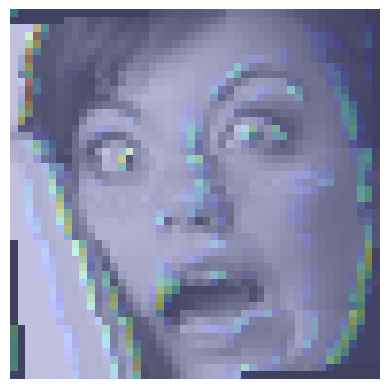

In [289]:
data_iter = iter(train)
images, labels = next(data_iter)
image = images[0].unsqueeze(0)
image = image.mean(dim=1, keepdim=True)

output = model(image)
class_idx = output.argmax(dim=1).item()
activation_map = cam_extractor(class_idx, output)[0]
activation_map = activation_map.mean(dim=0).cpu().detach().numpy()

activation_map -= activation_map.min()
activation_map /= activation_map.max()
activation_map = cv2.resize(activation_map, (48, 48))

plt.imshow(activation_map.squeeze(), cmap='jet', alpha=0.5)
plt.imshow(image.squeeze().cpu().detach().numpy(), cmap='gray', alpha=0.5)
plt.axis('off')
plt.show()

# Testing

In [46]:
def get_accuracy_ensemble(preds, target, batch_size):
    corrects = (preds == target).sum().item()
    return 100.0 * corrects / batch_size

In [69]:
def soft_voting_ensemble(models, input_batch):
    model_probs = []
    for i, model in enumerate(models_list):
        model = model.to(input_batch.device)
        model.eval()

        if i < 3: # cnn models, need 1 channel gray
            if input_batch.shape[1] == 3:
                current_input = input_batch.mean(dim=1, keepdim=True)
            else:
                current_input = input_batch
        else:  # vgg or res, need 3 channel gray, 224 x 224
            if input_batch.shape[1] == 1:
                current_input = input_batch.repeat(1, 3, 1, 1)
            current_input = torch.nn.functional.interpolate(current_input, size=(224, 224), mode='bilinear')
        input_batch = current_input

        with torch.no_grad():
            logits = model(input_batch)
            probs = torch.nn.functional.softmax(logits, dim=1)
            model_probs.append(probs)

    avg_probs = torch.stack(model_probs).mean(dim=0)
    final_preds = torch.argmax(avg_probs, dim=1)
    return final_preds, avg_probs

In [48]:
# ENSEMBLE TESTING ONLY
test_acc = 0.0
output = []

for images, labels in test:
    images, labels = images.to(device), labels.to(device)

    predictions, _ = soft_voting_ensemble(models, images)
    test_acc += get_accuracy_ensemble(predictions, labels, batch_size)
    output.extend(predictions.cpu().numpy())

print('Test Accuracy: %.2f' % (test_acc / len(test)))

Test Accuracy: 61.43


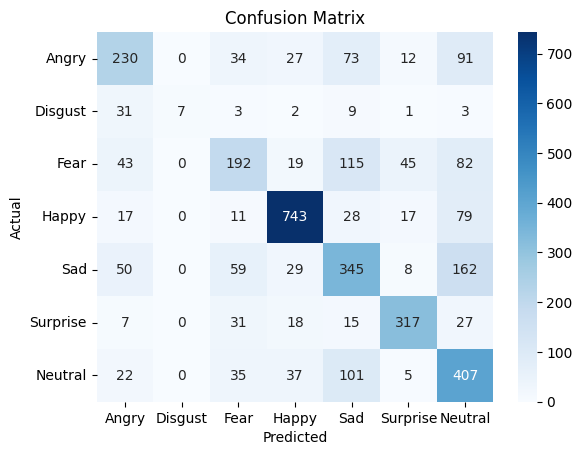

In [49]:
all_labels = []

for _, labels in test:
    all_labels.extend(labels.cpu().numpy())

all_labels = np.array(all_labels)

conf_matrix = confusion_matrix(all_labels, output)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
            yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [77]:
model = cnn3

In [65]:
model.eval()
test_acc = 0.0

for images, labels in test:
    images, labels = images.to(device), labels.to(device)

    _, logits = soft_voting_ensemble([model], images)
    test_acc += get_accuracy(logits, labels, batch_size)

print('Test Accuracy: %.2f' % (test_acc / len(test)))

Test Accuracy: 61.43


# Video Section

https://realpython.com/face-recognition-with-python/

https://www.geeksforgeeks.org/face-detection-using-cascade-classifier-using-opencv-python/

In [292]:
import time
import numpy as np
import cv2
import torch

grad_map = False

# Parameters for emotion smoothing
HISTORY_SIZE = 10
CONFIDENCE_THRESHOLD = 0.6

# Simple face filtering parameters
MIN_FACE_SIZE = 60
MIN_FACE_NEIGHBORS = 7
MAX_FACES = 1

frame_list = []
emotion = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Initialize emotion history tracker
emotion_history = []
current_display_emotion = 6

last_face_pos = None

video = cv2.VideoCapture('faces.mp4')
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

while True:
    ret, frame = video.read()

    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=MIN_FACE_NEIGHBORS,
        minSize=(MIN_FACE_SIZE, MIN_FACE_SIZE),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    if len(faces) > 0:
        faces = sorted(faces, key=lambda x: x[2] * x[3], reverse=True)
        x, y, w, h = faces[0]
        valid_face = True

        aspect_ratio = w / h
        if aspect_ratio < 0.5 or aspect_ratio > 2.0:
            valid_face = False

        if last_face_pos is not None:
            prev_x, prev_y, prev_w, prev_h = last_face_pos
            current_center = (x + w/2, y + h/2)
            prev_center = (prev_x + prev_w/2, prev_y + prev_h/2)
            distance = np.sqrt((current_center[0] - prev_center[0])**2 +
                            (current_center[1] - prev_center[1])**2)
            if distance > max(prev_w, prev_h):
                valid_face = True

        if valid_face:
            last_face_pos = (x, y, w, h)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            face = gray[y:y+h, x:x+w]
            model_input = cv2.resize(face, (48, 48)).astype(np.float32) / 255.0
            model_input = torch.tensor(model_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

            if grad_map:
                model_input.requires_grad_()
                out = model(model_input)
                pred_class = out.squeeze(0).argmax().item()

                cam = cam_extractor(pred_class, out)[0].detach().cpu().numpy()
                cam = np.squeeze(cam)

                cam_resized = cv2.resize(cam, (w, h))

                heatmap = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)
                heatmap = np.uint8(255 * heatmap)
                heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

                face_rgb = cv2.cvtColor(face, cv2.COLOR_GRAY2BGR)
                face_rgb_resized = cv2.resize(face_rgb, (w, h))
                overlay = cv2.addWeighted(face_rgb_resized, 0.5, heatmap_color, 0.5, 0)

                frame[y:y+h, x:x+w] = overlay

                cv2.putText(frame, emotion[pred_class], (x, y-10),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
            else:
                with torch.no_grad():
                    final_preds, logits = soft_voting_ensemble(models, model_input)
                    detected_emotion = int(final_preds.item())
                    emotion_history.append(detected_emotion)

                    if len(emotion_history) > HISTORY_SIZE:
                        emotion_history.pop(0)

                    emotion_count = {}
                    for e in emotion_history:
                        emotion_count[e] = emotion_count.get(e, 0) + 1

                    most_common_emotion = max(emotion_count, key=emotion_count.get)
                    frequency = emotion_count[most_common_emotion] / len(emotion_history)

                    if frequency >= CONFIDENCE_THRESHOLD:
                        current_display_emotion = most_common_emotion

                    confidence_text = f"{int(frequency * 100)}%"
                    emotion_text = f"{emotion[current_display_emotion]} ({confidence_text})"

                    cv2.putText(frame, emotion_text, (x, y-10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

                    raw_emotion_text = f"Raw: {emotion[detected_emotion]}"
                    cv2.putText(frame, raw_emotion_text, (x, y+h+20),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1)
        else:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(frame, "Invalid Face", (x, y-10),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    else:
        if emotion_history:
            cv2.putText(frame, "No face detected", (10, 30),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    frame_list.append(frame.copy())

frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))

video.release()

out = cv2.VideoWriter("face_detected_simple_filtering_la.mp4", cv2.VideoWriter_fourcc(*'MP4V'), fps, (frame_width, frame_height))

for frame in frame_list:
    out.write(frame)
out.release()